# Inertial Navigation System (INS)

4 May 2019

blah ...

# Extended Kalman Filter

### Model

$$
\dot x(t) = f(x(t), u(t)) + w(t) \quad w(t) \sim \mathcal{N}(0,Q(t))\\
z(t) = h(x(t)) + v(t) \quad v(t) \sim \mathcal{N}(0,R(t))
$$

### Initialize

$$
\hat x(t_0) = E[x(t_x)] \\
P(t_0) = Var[x(t_0)]
$$

### Predict-Update

$$
\dot{\hat x}(t) = f(\hat x(t), u(t)) + K(t)(z(t)-h(\hat x(t))) \\
\dot P(t)=F(t)P(t)+P(t)F(t)^T-K(t)H(t)P(t)+Q(t) \\
K(t)=P(t)H(t)^T R(t)^{-1} \\
F(t)=\frac{\partial f}{\partial x} \Bigr|_{\hat x(t), u(t)} \\
H(t)=\frac{\partial h}{\partial x} \Bigr|_{\hat x(t)}
$$

## References

- [Extended Kalman Filter](https://en.wikipedia.org/wiki/Extended_Kalman_filter)

In [1]:
%matplotlib inline

In [2]:
import numpy as np # matrix manipulations
from matplotlib import pyplot as plt
# pylab.rcParams['figure.figsize'] = (10.0, 10.0)

In [3]:
from math import sin, cos, atan2, pi, sqrt, asin
from math import radians as deg2rad
from math import degrees as rad2deg

In [4]:
from squaternion import Quaternion, euler2quat, quat2euler, quatNorm

In [5]:
import pickle

In [6]:
from pyrk import RK4

In [7]:
%ls

Inertial-Navigation-System.ipynb
accel-z-up.pickle*
imu-rpi.2019-05-04-20:47:18.445193.pickle.bag
misc/


In [8]:
# fname = "accel-z-up.pickle"
fname = "imu-rpi.2019-05-04-20:47:18.445193.pickle.bag"
data = pickle.load(open(fname,"rb"))

# data is an array of IMU messages
accel = data["accel"]
gyro = data["gyro"]
mag = data["mag"]

In [9]:
def normalize(x, y, z):
    """Return a unit vector"""
    norm = sqrt(x * x + y * y + z * z)

    # already a unit vector
    if norm == 1.0:
        return (x, y, z)

    if norm > 0.0:
        inorm = 1/norm
        x *= inorm
        y *= inorm
        z *= inorm
    else:
        raise Exception('division by zero: {} {} {}'.format(x, y, z))
    return (x, y, z,)

def skew4(wx, wy, wz):  # titterton 11.35
    return np.array([
        (0, -wx, -wy, -wz),
        (wx, 0, wz, -wy),
        (wy, -wz, 0, wx),
        (wz, wy, -wx, 0)
    ])

def skew3(wx, wy, wz):
    return np.array([
        (0, -wz, wy),
        (wz, 0, -wx),
        (-wy, wx, 0)
    ])

In [10]:
def gps2ecef(lat, lon, H):
    # phi = lat
    # lambda = lon
    # H = height above mean sea-level (altitude)
    e = 1.0
    re = 6378137.0  # radius of Earth in meters
    
    # convert degrees to angles
    lat *= pi/180
    lon *= pi/180
    
    rm = re * (1.0 - e**2) / pow(1.0 - e**2 * sin(lat)**2, 3.0 / 2.0)
    rn = re / sqrt(1.0 - e**2 * sin(lat)**2)
    x = (rn + H) * cos(lat) * cos(lon)
    y = (rn + H) * cos(lat) * sin(lon)
    z = (rm + H) * sin(lat)
    return x, y, z

In [11]:
class Sim(object):
    def __init__(self, eom, a, g, tm):
        self.eom = eom
        
        # grab the inertial sensors
        self.accels = a
        self.gyros = g
        self.dts = tm
    
    def run_nav(self):
        """
        These are the navigation only equations, no EKF corrections
        """
        rk = RK4(self.eom)
        
        # initial states
        vel = (0,0,0)
        pos = (0,0,0)
        orient = (1,0,0,0)
        X = np.array(vel + pos + orient)
        
        save = []
        
        last = self.dts[0]-0.1
        for i, tm in enumerate(self.dts):
            u = self.accels[i] + self.gyros[i]
            X = rk.step(X,u,tm,tm-last)
            last = tm
            save.append(X)
            
        print(">> Simulation end: {:.2f} seconds".format(tm))
        print(">> Steps: {} at {:0.3f} sec".format(len(save), np.mean(np.diff(self.dts))))
            
        return save, self.dts

In [12]:
accels = [(x[0][0],x[0][1],x[0][2],) for x in data["accel"]]
gyros = [(
    x[0][0] * pi / 180,
    x[0][1] * pi / 180,
    x[0][2] * pi / 180,) for x in data["gyro"]]

s = data["accel"][0][1]
stamps = [x[1] - s for x in data["accel"]]

# Find biases ------------------- 
ax = np.mean([x[0] for x in accels])
ay = np.mean([x[1] for x in accels])
az = np.mean([x[2] for x in accels]) - 1.0
print('Accels mean: {:.4f} {:.4f} {:.4f}'.format(ax,ay,az))

gx = np.mean([x[0] for x in gyros])
gy = np.mean([x[1] for x in gyros])
gz = np.mean([x[2] for x in gyros])
print('Gyro mean: {:.4f} {:.4f} {:.4f}'.format(gx,gy,gz))

# Correct ----------------------
accels = [(
    x[0] - ax,
    x[1] - ay,
    x[2] - az,) for x in accels]
gyros = [(
    x[0] - gx,
    x[1] - gy,
    x[2] - gz,) for x in gyros]

Accels mean: 0.0406 -0.0385 0.0243
Gyro mean: 0.0131 -0.0206 -0.0015


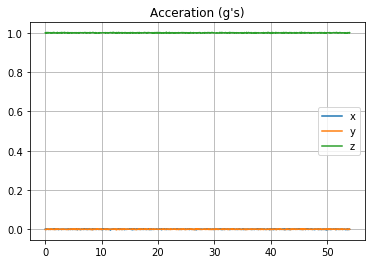

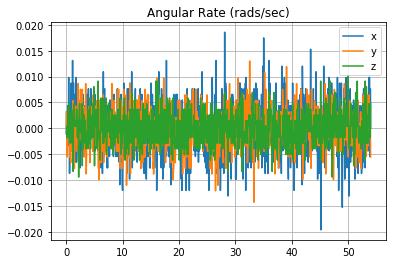

In [13]:
for s, title in zip([accels, gyros], ['Acceration (g\'s)', 'Angular Rate (rads/sec)']):
    plt.figure()
    plt.plot(stamps, [x[0] for x in s], label='x')
    plt.plot(stamps, [x[1] for x in s], label='y')
    plt.plot(stamps, [x[2] for x in s], label='z')
    plt.grid(True)
    plt.title(title)
    plt.legend()

In [14]:
# System equations of motion (eom)
# these follow the Titterton ECEF derivation
def eom(t, X, u):
    """
    State vector
    X = tuple[vx vy vz px py pz qw qx qy qz]
    v - velocity
    p - position
    q - quaternion (orientation)

    These are sensor readings from IMU
    u = [fx fy fz wx wy wz]
    f - force (acceleration)
    w - angular velocity (from gyros)
    """
    # imu ---------------------
    f = 9.81*np.array(u[0:3]) 
    wx, wy, wz = u[3:]
    W = skew4(wx, wy, wz)
    
    # state -------------------
    v = np.array(X[0:3])
    p = np.array(X[3:6])
    q = np.array(X[6:])
    
    # nav const --------------
    wie = np.array([0, 0, 7.292115E-15])
    Ceb = np.eye(3) # ???
    g = np.array([0,0,-9.81])
    
    # update local gravity model
    gl = g - np.cross(wie, np.cross(wie, p))
    
    # velocity update
    vd = Ceb.dot(f)-2.0*np.cross(wie, np.cross(wie, v)) + gl
    
    # position update
    pd = v
    
    # orientation update
    qd = 0.5 * W.dot(q)

    # print('vd', vd)
    # print('pd', pd)
    # print('qd', qd)

    XX = np.hstack((vd, pd, qd))
    return XX

In [15]:
s = Sim(eom, accels, gyros, stamps)
X, timestamps = s.run_nav()

>> Simulation end: 54.01 seconds
>> Steps: 1000 at 0.054 sec


In [16]:
vel = [x[:3] for x in X]
pos = [x[3:6] for x in X]
orient = [x[6:] for x in X]

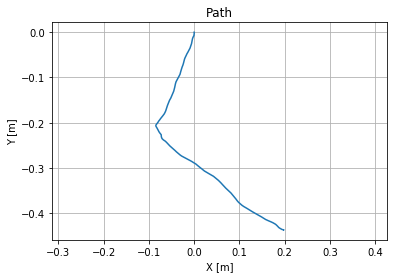

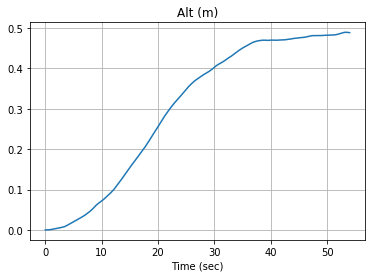

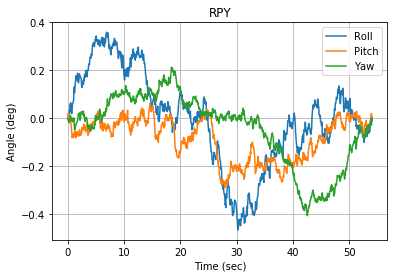

In [17]:
x = [x[0] for x in pos]
y = [x[1] for x in pos]
z = [x[2] for x in pos]

plt.figure()
plt.plot(x,y)
plt.grid(True)
plt.axis('equal')
plt.title('Path')
plt.ylabel('Y [m]')
plt.xlabel('X [m]')

plt.figure()
plt.plot(timestamps, z)
plt.xlabel('Time (sec)')
plt.grid(True)
plt.title('Alt (m)')

rpy = [quat2euler(*x, degrees=True) for x in orient]
r = [x[0] for x in rpy]
p = [x[1] for x in rpy]
y = [x[2] for x in rpy]

plt.figure()
plt.plot(timestamps, r, label='Roll')
plt.plot(timestamps, p, label='Pitch')
plt.plot(timestamps, y, label='Yaw')
plt.grid(True)
plt.xlabel('Time (sec)')
plt.ylabel('Angle (deg)')
plt.legend()
plt.title('RPY');

In [53]:
def eom2(t, X, u):
    """
    State vector
    X = tuple[vx vy vz px py pz qw qx qy qz]
    v - velocity
    p - position
    q - quaternion (orientation)

    These are sensor readings from IMU
    u = [fx fy fz wx wy wz]
    f - force (acceleration)
    w - angular velocity (from gyros)
    """
    # imu ---------------------
    f = 9.81*np.array(u[0:3]) 
    wx, wy, wz = u[3:]
    W = skew4(wx, wy, wz)
    
    # state -------------------
    v = np.array(X[0:3])
    p = np.array(X[3:6])
    q = np.array(X[6:])
    
    # nav const --------------
    wie = np.array([0, 0, 7.292115E-15])
    Ceb = Cne.dot(Cnb)
    g = np.array([0,0,-9.81])
    
    # update local gravity model
    gl = g - np.cross(wie, np.cross(wie, p))
    
    # velocity update
    vd = Ceb.dot(f)-2.0*np.cross(wie, np.cross(wie, v)) + gl
    
    # position update
    pd = v
    
    # orientation update
    qd = 0.5 * W.dot(q)

    # print('vd', vd)
    # print('pd', pd)
    # print('qd', qd)

    XX = np.hstack((vd, pd, qd))
    return XX

In [54]:
class EKF(object):
    """
    Extended Kalman Filter (EKF)

    def func(time, x, u):
        some nonlinear eqns
        return dx

    ekf = EKF(size_x,size_z)
    ekf.init(x, func, R, Q)

    while True:
        ekf.predict(u)
        x_hat = ekf.update(z)
    """
    def __init__(self, dim_x, dim_z, dt):
        self.dt = dt
        self.H = np.eye(dim_z)
        self.P = np.eye(dim_x)
        self.I = np.eye(dim_x)

    def init(self, x, f, r, q):
        """
        f: dx = f(x, u)
        r: measurement noise
        q: process noise
        """
        self.x = x
        self.rk = RK4(f)
        self.R = r
        self.Q = q
        self.time = 0.0

    def predict(self, u):
        # predict state estimate
        rk = self.rk
        dt = self.dt
        t = self.time
        x = self.x

        y = rk.step(x, u, t, dt)
        F = np.Jacobian(y)

        self.time = t+dt
        self.x = y

        # predict covariance estimate
        Q = self.Q
        P = self.P

        self.P = dot(F, dot(P, F.T)) + Q

    def update(self, z):
        H = self.H
        R = self.R
        I = self.I
        P = self.P
        x = self.x

        K = dot(P, dot(H.T, inv(dot(H, dot(P, H.T)) + R)))
        x = x + K.dot(z-H)
        p = (I - K.dot(H)).dot(P)

        self.x = x
        self.P = p

        return x

In [55]:
def ins_corr(t,X,u):
    """
    Chatfield equations
    """
    wie = np.array([0,0,7.29211E-15])
    web = np.array([0,0,0])  # FIXME
    
    V = tuple(X[0:3])
    P = tuple(X[3:6])
    O = tuple(X[6:9])
    S = tuple(X[9:12])
    w = tuple(X[12:15])
    
    Reb = np.array([  # FIXME
        [1,0,0],
        [0,1,0],
        [0,0,1]
    ])
    
    Vd = -2*np.cross(wie,V) + np.cross(wie, np.cross(wie, P)) + np.cross(S, O) + Reb*S
    Pd = V
    Od = np.cross(web, O) - Reb*w
    Sd = Sn
    wd = wn

In [58]:
cos(45)

0.5253219888177297

In [59]:
cos(pi/4)

0.7071067811865476

In [78]:
class Sim2(object):
    def __init__(self, a, g, tm):
        
        # grab the inertial sensors
        self.accels = a
        self.gyros = g
        self.dts = tm
    
    def run_ins(self, nav, corr):
        """
        These are the navigation only equations, no EKF corrections
        """
        nav_rk = RK4(nav)
        ekf = EKF(15,15,0.05)
        ekf.init(x,ins_corr,0.001*np.eye(3),0.001*np.eye(3))
        
        # initial states
        vel = (0,0,0)
        pos = (0,0,0)
        orient = (1,0,0,0)
        X = np.array(vel + pos + orient)
        
        save_nav = []
        
        XX = np.zeros(15)
        
        last = self.dts[0]-0.1
        for i, tm in enumerate(self.dts):
            u = self.accels[i] + self.gyros[i]
            X = nav_rk.step(X,u,tm,tm-last)
            last = tm
            save_nav.append(X)
            ekf
            
        print(">> Simulation end: {:.2f} seconds".format(tm))
        print(">> Steps: {} at {:0.3f} sec".format(len(save), np.mean(np.diff(self.dts))))
            
        return save, self.dts

In [79]:
s = Sim2(accels, gyros, stamps)

In [ ]:
X, timestamps = s.run_ins()

# Discrete

In [144]:
def discrete(accel, gyro):
    gc = np.mean([x[0][0] for x in gyro])
    axc = np.mean([x[0][0] for x in accel])
    ayc = np.mean([x[0][1] for x in accel])
    azc = np.mean([x[0][2] for x in accel])
    print("axc: {:.4f}  ayc: {:.4f}  azc: {:.4f}".format(axc,ayc,azc))
    roll = 0
    told = gyro[0][1]
    tstart = told
    cfilter = 0.85
    save = []
    savea = []
    savet = []
    for (w, t), (a, t) in zip(gyro, accel):
        an = sqrt((a[0]-axc)**2 + (a[2]-azc+1)**2)
        ax = atan2(a[1]-ayc, an)*180/pi  # y/z
        savea.append(ax)
        
        roll += (w[0]-gc)*(t-told)*cfilter + ax*(1-cfilter)  # complementary filter
        told = t
        savet.append(t-tstart)
        save.append(roll)
    plt.plot(savet,save,label="gyro")
    plt.plot(savet,savea,label='accel')
    plt.legend()
    plt.grid(True)

axc: 0.0406  ayc: -0.0385  azc: 1.0243


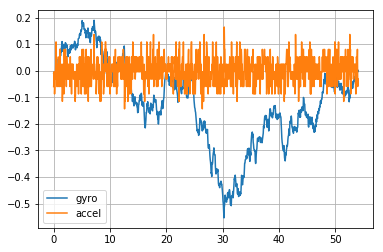

In [145]:
discrete(accel, gyro)

In [39]:
accel[1][1] - accel[0][1]

0.052555084228515625

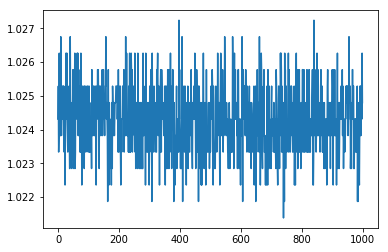

In [83]:
plt.plot([x[0][2] for x in accel])